In [1]:
%load_ext autoreload
%autoreload 2

import pathlib
import pickle
import os

import numpy as np
import pandas as pd

import scipy

import mne
from matplotlib import pyplot as plt

import constants
import dataset
import folders
import iter_topography_fork
import analysis_and_plotting_functions as aps

In [2]:
plt.rcParams['figure.figsize'] = [12,6]

In [3]:
# Load dataset into memory (if short on memory, use preload=False)
ds = dataset.DatasetReader(data_path=folders.database_path, preload=True)

100 percent complete

This analysis is using cluster-based permutation test for comparing different subsets of evoked data.
First, let's try to cluster target vs non-target ERPs. The differences are supposed to exist, as it is the basis of the P300 BCI parading. This is to serve as the illustration of the method - we can see, that the CBPT can capture differences, that exist in all channels, as a cluster.

[                                                            ]   0.00%  |
[0.001]
(2, 20, 451, 45) (2, 451, 45)
Mean F-score for cluster 10.059847557710802
Cluster channels ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']


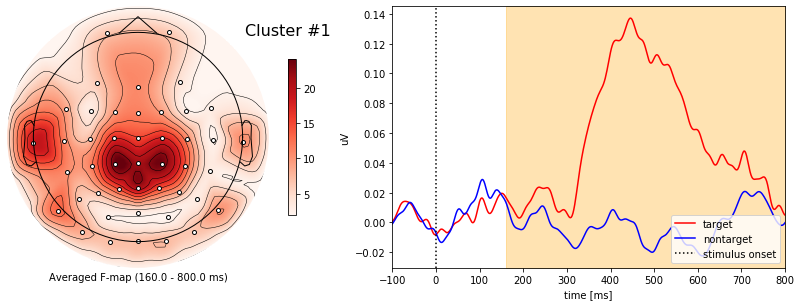

In [4]:
target = []
nontarget = []
condition_names = ['target', 'nontarget']

for user in set(ds.markup['user']):
    subset_user= ds.markup.loc[ (ds.markup['user'] == user) &
                                (ds.markup['reg'] == 'large')]
    ep=aps.subset(ds, subset_user)
    
    target.append(ep['target'])
    nontarget.append(ep['nontarget'])

X = [np.array([a.data.T for a in target]), 
     np.array([a.data.T for a in nontarget])]
info = nontarget[0].info
times = nontarget[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times,  condition_names=condition_names,
                    threshold=None, n_permutations=1000, n_jobs=-1, plot_range=False)

# Compare blind and sigted subjects.

Function for comparing different EP types in blind and sighted

In [13]:
def blind_vs_sigted(reg, tmax, ep_type):
    blind = []
    sighted = []
    condition_names = ['blind', 'sighted']
    
    for user in set(ds.markup.loc[ds.markup['blind'] == 1]['user']):
        for session in set(ds.markup.loc[ds.markup['user'] == user]['session_id']):
            subset_blind = ds.markup.loc[   (ds.markup['user'] == user) &
                                            (ds.markup['reg'] == reg) &
                                            (ds.markup['session_id'] == session)]
            blind.append(aps.subset(ds, subset_blind)[ep_type].crop(tmax=0.8, tmin=0))

    for user in set(ds.markup.loc[ds.markup['blind'] == 0]['user']):
        for session in set(ds.markup.loc[ds.markup['user'] == user]['session_id']):
            subset_sighted = ds.markup.loc[ (ds.markup['user'] == user) &
                                            (ds.markup['reg'] == reg) &
                                            (ds.markup['session_id'] == session)]
            sighted.append(aps.subset(ds, subset_sighted)[ep_type].crop(tmax=0.8, tmin=0))

    X = [np.array([a.data.T for a in blind]), 
        np.array([a.data.T for a in sighted])]
    info = blind[0].info
    times = blind[0].times * 1e3

    stats = aps.cluster_and_plot(X, info, times, condition_names=condition_names,
                        threshold=None, n_permutations=10000, tail=1, n_jobs=1, cutoff_pval=0.05, spatial_exclude=[0,1])

### Compare differential EPs in blind and sighted for small stimuli

None
[............................................................] 100.00%  |
[0.0013 0.0034]
(2, 160, 401, 45) (2, 401, 45)
Mean F-score for cluster 3.595517887000306
Cluster channels ['F3', 'FC5', 'T7', 'C5', 'C3', 'T8', 'CP5', 'CP3', 'CP1', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']


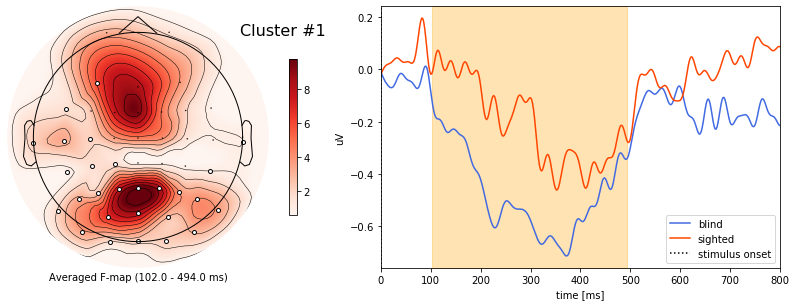

Mean F-score for cluster 4.091459946504982
Cluster channels ['F3', 'Fz', 'F4', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4']


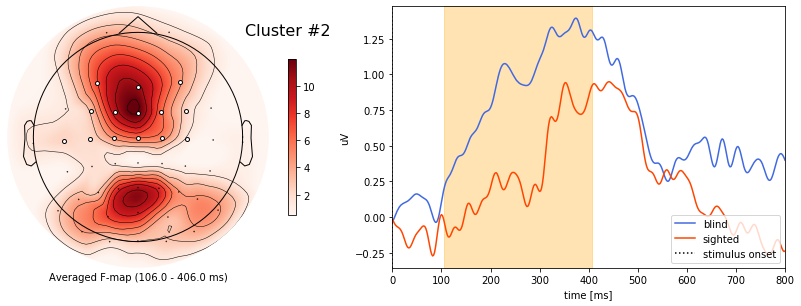

In [15]:
blind_vs_sigted(reg='small', tmax=0.8, ep_type='delta')

### Now, the same for large stimuli. We can see essentially the same clusters, that are less pronounced because of lower signal-to-noise ration in sighted.

None
[............................................................] 100.00%  |
[0.0041]
(2, 160, 401, 45) (2, 401, 45)
Mean F-score for cluster 3.00528888348779
Cluster channels ['F3', 'Fz', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'C1', 'Cz', 'C2']


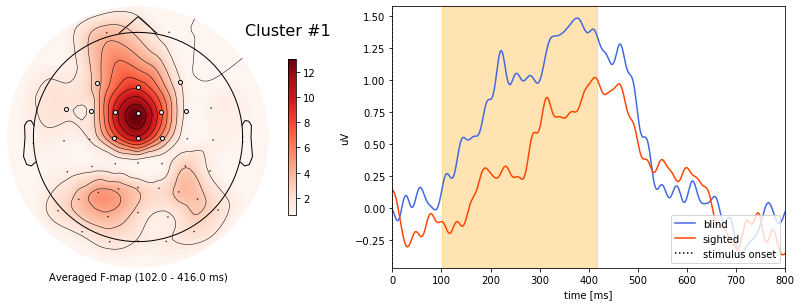

In [14]:
blind_vs_sigted(reg='large', tmax=0.8, ep_type='delta')

### Importantly, the variance in sighted subjects is larger. This can be one of the reasons for better performance in blind subjects, along with higher amplitudes
It's the effect is significant for most channels and time points (assessed with homoschedasticity tests, like Kolmogorov-Smirnov)
The following snippet is for illustrative purposes only - it doesn't make sense to interpret CBPT ob variances.

[                                                            ]   0.00%  |
[0.001]
(2, 160, 401, 45) (2, 401, 45)
Mean F-score for cluster 26.95482154641155
Cluster channels ['Fp1', 'Fp2', 'F3', 'Fz', 'F4', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2']


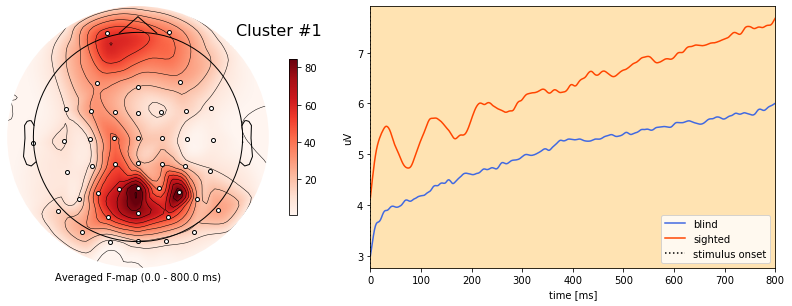

In [8]:
blind = []
sighted = []
condition_names = ['blind', 'sighted']


for user in set(ds.markup.loc[ds.markup['blind'] == 1]['user']):
    for session in set(ds.markup.loc[ds.markup['user'] == user]['session_id']):
        subset_blind = ds.markup.loc[   (ds.markup['user'] == user) &
                                        (ds.markup['reg'] == 'large') &
                                        (ds.markup['session_id'] == session)
                                    ]
        variance = aps.subset(ds, subset_blind, quantiles=[0.25,0.75])['quantiles']['target']['std']
        blind.append(variance.crop(tmax=0.8, tmin=0))

for user in set(ds.markup.loc[ds.markup['blind'] == 0]['user']):
    for session in set(ds.markup.loc[ds.markup['user'] == user]['session_id']):
        subset_sighted = ds.markup.loc[ (ds.markup['user'] == user) &
                                        (ds.markup['reg'] == 'large') &
                                        (ds.markup['session_id'] == session)
                                    ]
        variance = aps.subset(ds, subset_sighted, quantiles=[0.25,0.75])['quantiles']['target']['std']
        sighted.append(variance.crop(tmax=0.8, tmin=0))


X = [np.array([a.data.T for a in blind]), 
    np.array([a.data.T for a in sighted])]
info = blind[0].info
times = blind[0].times * 1e3

stats = aps.cluster_and_plot(X, info, times, condition_names=condition_names,
                    threshold=None, n_permutations=1000, tail=1, n_jobs=-1, cutoff_pval=0.05, plot_range=False)

# Compare evoked responces in left and right hand

In [9]:
def right_vs_left(user_set:list, reg:str, tmax:float, ep_type:str):
    right_hand = []
    left_hand = []
    condition_names = ['left_hand', 'right_hand']

    for user in user_set:

        subset_right = ds.markup.loc[ (ds.markup['user'] == user) &
                                    (ds.markup['reg'] == reg) &
                                    (ds.markup['finger'].isin([7,6,5,4]))
                                    ]

        subset_left = ds.markup.loc[ (ds.markup['user'] == user) &
                                    (ds.markup['reg'] == reg) &
                                    (ds.markup['finger'].isin([0,1,2,3]))
                                    ]

        right_hand.append(aps.subset(ds, subset_right)[ep_type].crop(tmax=tmax, tmin=0))
        left_hand.append(aps.subset(ds, subset_left)[ep_type].crop(tmax=tmax, tmin=0))


    X = [np.array([a.data.T for a in left_hand]), 
        np.array([a.data.T for a in right_hand])]
    info = left_hand[0].info
    times = left_hand[0].times * 1e3

    stats = aps.cluster_and_plot(X, info, times,  condition_names=condition_names,
                        threshold=None, n_permutations=1000, n_jobs=-1)

## Sighted subjects, nontarget EPs

### Try it in all users, both in blind and sighted.

### Large stimuli:

[                                                            ]   0.00%  |
[0.002 0.002]
(2, 20, 151, 45) (2, 151, 45)
Mean F-score for cluster 7.675229552327942
Cluster channels ['Fp1', 'F3', 'FC5', 'FC3', 'FC1', 'T7', 'C5', 'C3', 'C1', 'CP5', 'CP3', 'CP1', 'P7', 'P5', 'P3', 'P1', 'PO7', 'PO3', 'O1', 'Oz']


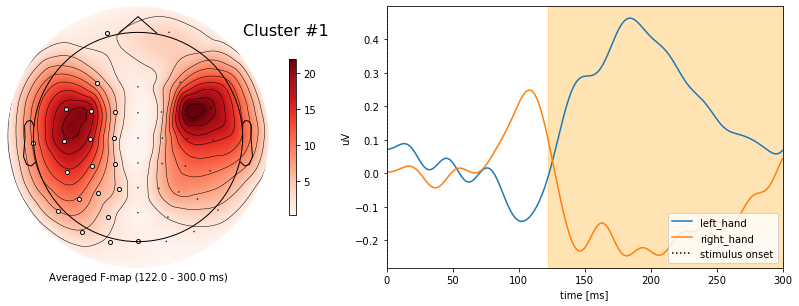

Mean F-score for cluster 7.736375738471315
Cluster channels ['Fp1', 'Fp2', 'F4', 'FC2', 'FC4', 'FC6', 'C2', 'C4', 'C6', 'T8', 'CP2', 'CP4', 'CP6', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8', 'O2']


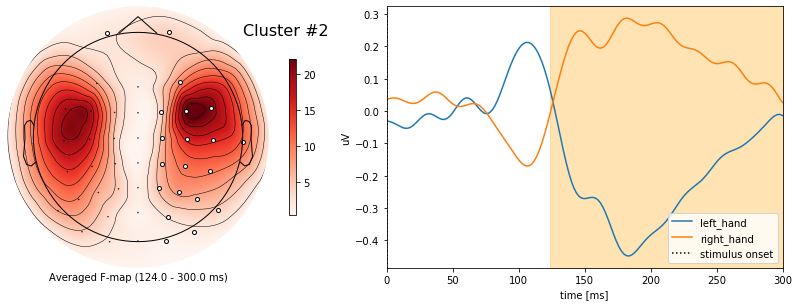

In [10]:
user_set = set(ds.markup['user'])
right_vs_left(user_set=user_set,
             reg='large',
             tmax=0.3,
             ep_type='nontarget')

### Small stimuli:

[                                                            ]   0.00%  |
[0.001 0.001]
(2, 20, 151, 45) (2, 151, 45)
Mean F-score for cluster 6.987134774155636
Cluster channels ['F3', 'FC5', 'FC3', 'FC1', 'T7', 'C5', 'C3', 'C1', 'CP5', 'CP3', 'CP1', 'P7', 'P5', 'P3', 'P1', 'PO7', 'PO3', 'O1', 'Oz']


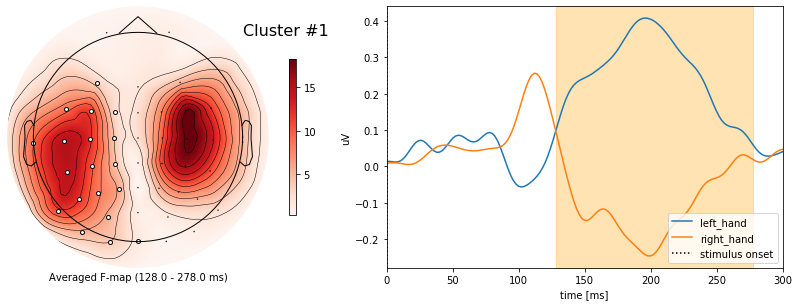

Mean F-score for cluster 6.297925759271071
Cluster channels ['Fp2', 'Fz', 'F4', 'FCz', 'FC2', 'FC4', 'FC6', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CP2', 'CP4', 'CP6', 'P2', 'P4', 'P6', 'P8', 'PO4']


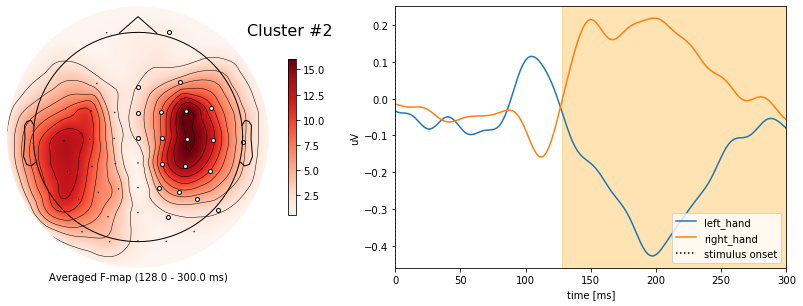

In [11]:
user_set = set(ds.markup['user'])
right_vs_left(user_set=user_set,
             reg='small',
             tmax=0.3,
             ep_type='nontarget')

We can see inversed laterality of nontarget evoked potentials, as expected (see raw EP visualization)
We also can run the same analysis for blind and sighted alone, yielding essentially the same result.

[                                                            ]   0.00%  |
[0.004 0.003]
(2, 10, 151, 45) (2, 151, 45)
Mean F-score for cluster 4.692825544136543
Cluster channels ['Fp2', 'F4', 'FC2', 'FC4', 'FC6', 'C2', 'C4', 'C6', 'T8', 'CP2', 'CP4', 'CP6', 'P2', 'P4', 'P6', 'P8']


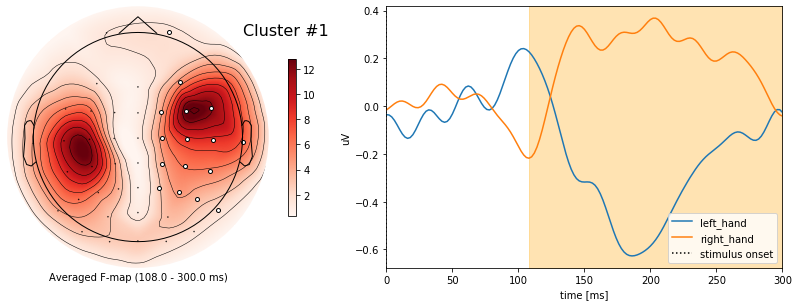

Mean F-score for cluster 5.035268394973742
Cluster channels ['F3', 'FC5', 'FC3', 'FC1', 'T7', 'C5', 'C3', 'C1', 'CP5', 'CP3', 'CP1', 'P7', 'P5', 'P3', 'P1', 'PO7', 'PO3', 'O1', 'Oz']


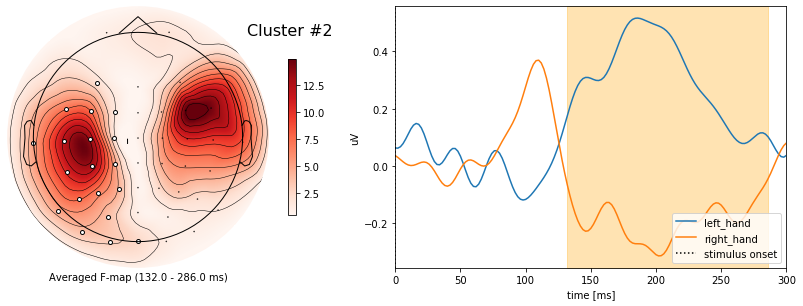

[                                                            ]   0.00%  |
[0.006 0.005]
(2, 10, 151, 45) (2, 151, 45)
Mean F-score for cluster 4.6927996741894535
Cluster channels ['Fp2', 'F4', 'FC2', 'FC4', 'FC6', 'C2', 'C4', 'C6', 'T8', 'CP2', 'CP4', 'CP6', 'P2', 'P4', 'P6', 'P8']


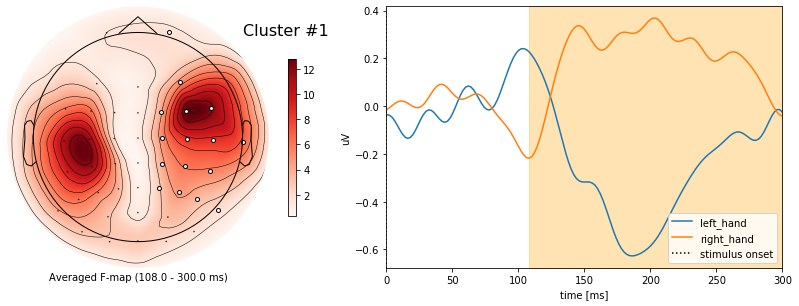

Mean F-score for cluster 5.035248175443689
Cluster channels ['F3', 'FC5', 'FC3', 'FC1', 'T7', 'C5', 'C3', 'C1', 'CP5', 'CP3', 'CP1', 'P7', 'P5', 'P3', 'P1', 'PO7', 'PO3', 'O1', 'Oz']


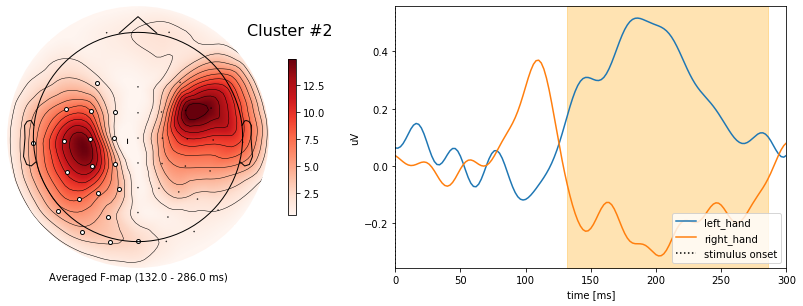

[                                                            ]   0.00%  |
[0.013 0.02 ]
(2, 10, 151, 45) (2, 151, 45)
Mean F-score for cluster 3.2311019981474614
Cluster channels ['F3', 'FC5', 'FC3', 'FC1', 'T7', 'C5', 'C3', 'C1', 'CP5', 'CP3', 'CP1', 'P7', 'P5', 'P3', 'P1', 'PO7', 'PO3', 'O1']


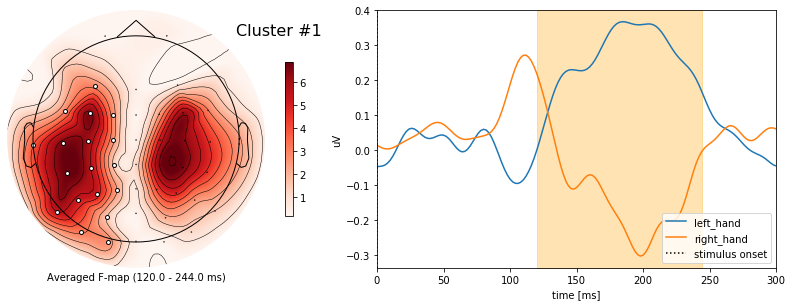

Mean F-score for cluster 3.146267732149994
Cluster channels ['FC2', 'FC4', 'FC6', 'C2', 'C4', 'C6', 'T8', 'CPz', 'CP2', 'CP4', 'CP6', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8']


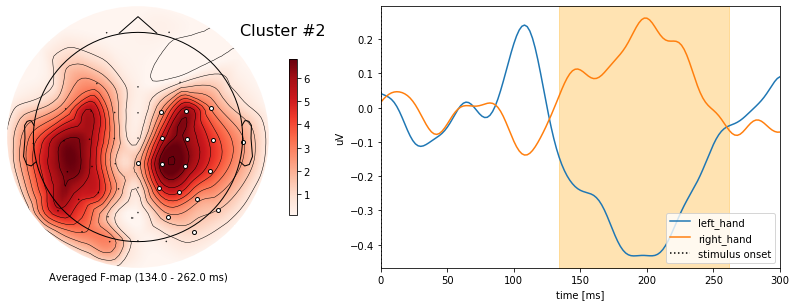

[                                                            ]   0.00%  |
[0.009 0.014]
(2, 10, 151, 45) (2, 151, 45)
Mean F-score for cluster 3.231102268695399
Cluster channels ['F3', 'FC5', 'FC3', 'FC1', 'T7', 'C5', 'C3', 'C1', 'CP5', 'CP3', 'CP1', 'P7', 'P5', 'P3', 'P1', 'PO7', 'PO3', 'O1']


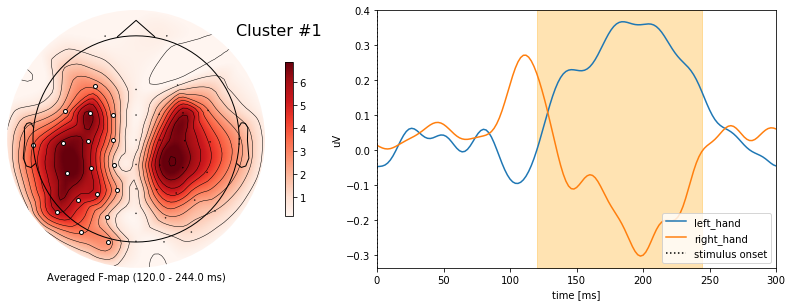

Mean F-score for cluster 3.1462640484848836
Cluster channels ['FC2', 'FC4', 'FC6', 'C2', 'C4', 'C6', 'T8', 'CPz', 'CP2', 'CP4', 'CP6', 'P2', 'P4', 'P6', 'P8', 'PO4', 'PO8']


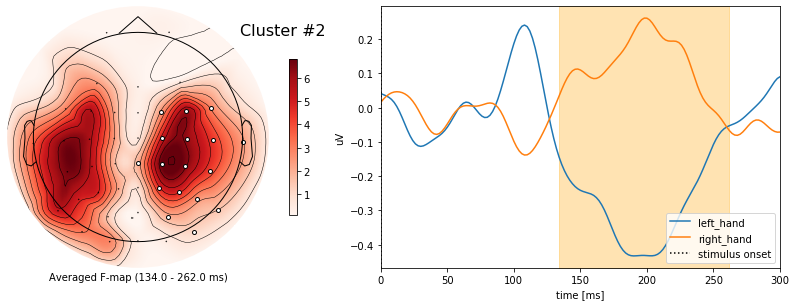

In [12]:
#Blind, large
user_set = set(ds.markup.loc[ds.markup['blind'] == 0]['user'])
right_vs_left(user_set=user_set,
             reg='large',
             tmax=0.3,
             ep_type='nontarget')
#Sighted, large
user_set = set(ds.markup.loc[ds.markup['blind'] == 0]['user'])
right_vs_left(user_set=user_set,
             reg='large',
             tmax=0.3,
             ep_type='nontarget')
#Blind, small
user_set = set(ds.markup.loc[ds.markup['blind'] == 0]['user'])
right_vs_left(user_set=user_set,
             reg='small',
             tmax=0.3,
             ep_type='nontarget')
#Sighted, small
user_set = set(ds.markup.loc[ds.markup['blind'] == 0]['user'])
right_vs_left(user_set=user_set,
             reg='small',
             tmax=0.3,
             ep_type='nontarget')

## When comparing right and left on differential ERP, there are no interpretable significant clusters.

In [13]:
user_set = set(ds.markup['user'])
right_vs_left(user_set=user_set,
             reg='large',
             tmax=0.8,
             ep_type='delta')

[                                                            ]   0.00%  |
No significant clusters found
(2, 20, 401, 45) (2, 401, 45)
